# Machine Learning & Deep Learning 
#for Histopathology Diagnosis





This file contains the final code for both the Random Forest and Convolutional Neural Network models

# RF

In [ ]:
#First lets import all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import os
import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from skimage import color
from sklearn.cluster import KMeans
from scipy import ndimage as nd
import cv2
from skimage.filters import roberts, sobel, scharr, prewitt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import numpy as np
import cv2
import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Next we load the metadata and explore the dataset

df=pd.read_csv('/content/annotations.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 4 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Image Name                                        3152 non-null   object
 1   Majority Vote Label                               3152 non-null   object
 2   Number of Annotators who Selected SSA (Out of 7)  3152 non-null   int64 
 3   Partition                                         3152 non-null   object
dtypes: int64(1), object(3)
memory usage: 98.6+ KB


<Axes: xlabel='Majority Vote Label', ylabel='Count'>

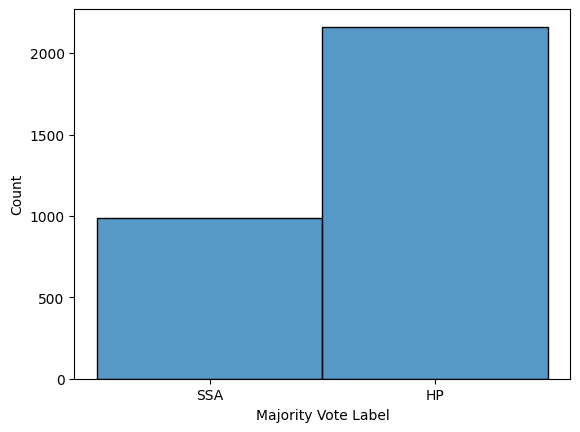

In [ ]:
#We drop the prelabeled "partition" column so that we can further preprocess the data 

df=df.drop('Partition',axis=1)
sns.histplot(data=df['Majority Vote Label'])

<Axes: xlabel='count', ylabel='Number of Annotators who Selected SSA (Out of 7)'>

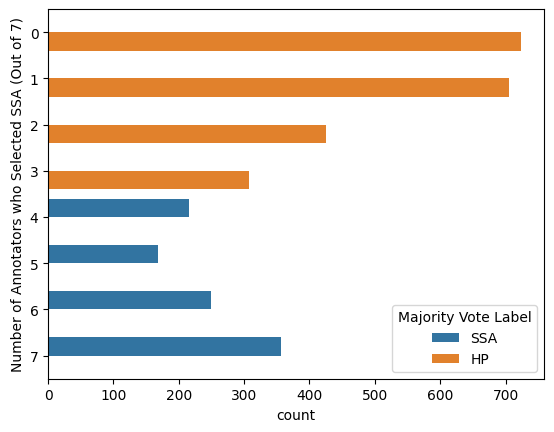

In [ ]:
sns.countplot(data=df, y=df['Number of Annotators who Selected SSA (Out of 7)'], hue=df['Majority Vote Label'])

<Axes: xlabel='count', ylabel='Number of Annotators who Selected SSA (Out of 7)'>

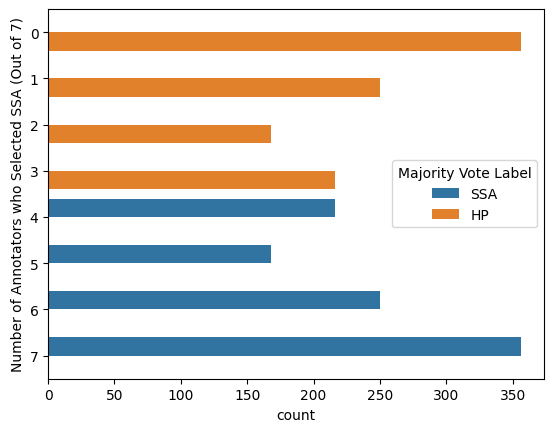

In [ ]:
#We balance the data for training our model.

k=df['Number of Annotators who Selected SSA (Out of 7)'].value_counts()

dc=k.to_dict()

# directory path where the images are stored
directory_path = 'I:/Datasets/MHIST Datasets/images/'

# get the sorted list of keys
sorted_keys = sorted(dc.keys())

# get the number of keys
num_keys = len(sorted_keys)


del_n_rows=[]

# loop over the first half of the keys
for i in range(num_keys // 2):
    # get the corresponding values using indexing and slicing
    first_key = sorted_keys[i]
    last_key = sorted_keys[-i-1]
    first_value = dc[first_key]
    last_value = dc[last_key]
    
    # calculate the difference and print the result
    diff = abs(last_value - first_value)
    del_n_rows.append(diff)

for i in range(num_keys // 2):    
    to_delete = df.loc[df['Number of Annotators who Selected SSA (Out of 7)'] == sorted_keys[i]].sample(n=del_n_rows[i]).index
    df = df.drop(to_delete)
    
sns.countplot(data=df, y=df['Number of Annotators who Selected SSA (Out of 7)'], hue=df['Majority Vote Label'])

In [ ]:
#In this step we remove unnecessary rows and binarize our objective column
df=df.drop('Number of Annotators who Selected SSA (Out of 7)',axis=1)
df['Majority Vote Label'].replace({'SSA': 1, 'HP': 0}, inplace=True)
df.rename(columns={'Majority Vote Label': 'SSA Detected?'}, inplace=True)
df['SSA Detected?'] = pd.to_numeric(df['SSA Detected?'], downcast='integer')

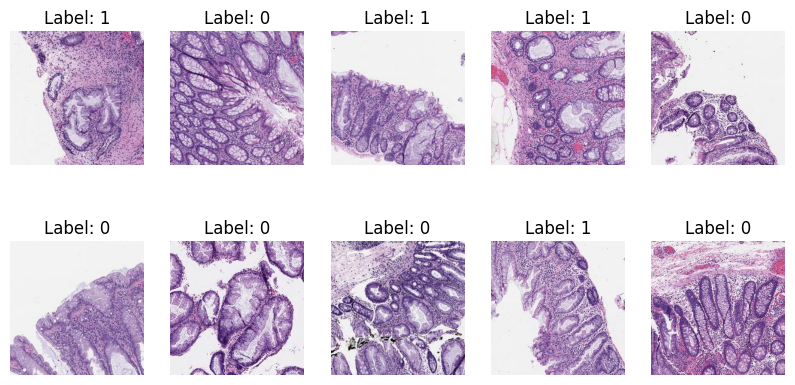

In [ ]:
#In this step we load the images based on our preprocessed metadata
directory_path = '/content/drive/MyDrive/MHIST'

# list to store the images and labels
images = []
labels = []

# loop through each row in the DataFrame and append the image data and label to the lists
for index, row in df.iterrows():
    filename = row['Image Name']
    label = row['SSA Detected?']
    img_path = os.path.join(directory_path, filename)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        images.append(img)
        labels.append(label)
    else:
        print(f"Image {filename} not found")

# define the grid dimensions for subplots
rows = 2
cols = 5

# create a new figure with the given dimensions
fig = plt.figure(figsize=(10, 5))

# loop through the images and their corresponding labels and display them as subplots
for i in range(rows * cols):
    # check if there are still images and labels left to display
    if i >= len(images) or i >= len(labels):
        break
    # plot the image in a subplot
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(images[i])
    ax.axis('off')
    # add the corresponding label as the title of the subplot
    ax.set_title(f"Label: {labels[i]}")
    
plt.show()

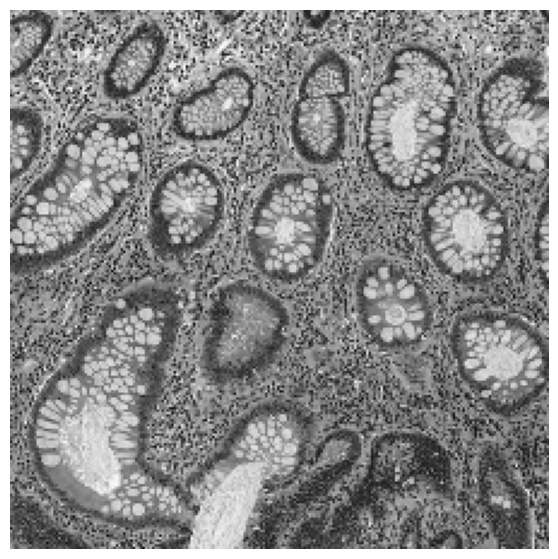

In [ ]:
# We pick a random image for checking Segmentation 
image1=images[99]
image1= color.rgb2gray(image1)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image1, cmap='gray')
ax.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

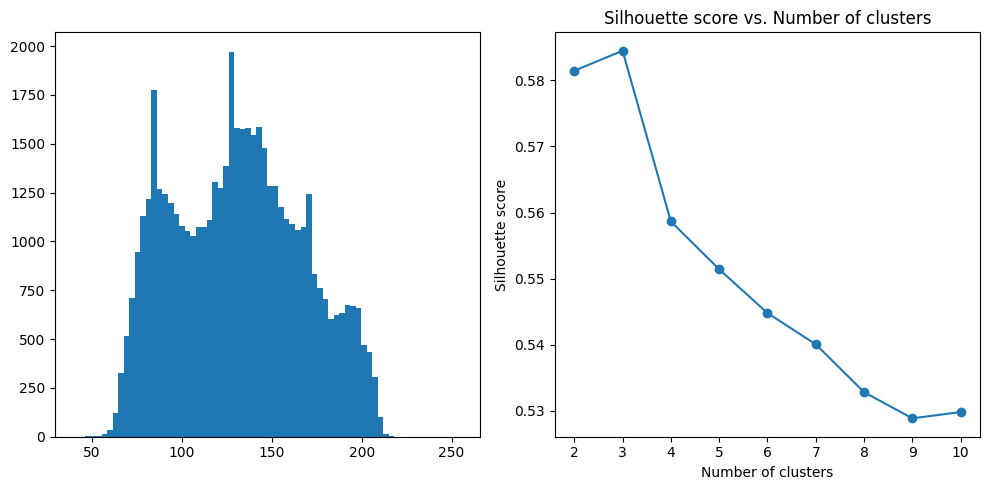

In [ ]:
#In this step we denoise the image and see the pixel distribution histogram to find the optimum number of clusters

# Load and preprocess the image as shown in the previous code snippet
float_img = img_as_float(image1)
sigma_est = np.mean(estimate_sigma(float_img))
denoise_img = denoise_nl_means(float_img, h=0.7 * sigma_est, fast_mode=True, patch_size=2, patch_distance=30)
denoise_img_as_8byte = img_as_ubyte(denoise_img)

# plt.hist(denoise_img_as_8byte.flat, bins=70, range=(40,255)) 

pixel_values = denoise_img_as_8byte.reshape((-1, 1))

from sklearn.metrics import silhouette_score

# Calculate the Silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    labels = kmeans.fit_predict(pixel_values)
    score = silhouette_score(pixel_values, labels)
    silhouette_scores.append(score)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the histplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(denoise_img_as_8byte.flat, bins=70, range=(40,255)) 

# Plot the Silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. Number of clusters')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


we chose 4 clusters, regardless the fact that the silhouette suggests 3, as we already know there are 4 textures: cells and gland outlines, mucosa, goblet cells and empty cells

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-12-a70ac9f123d0>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


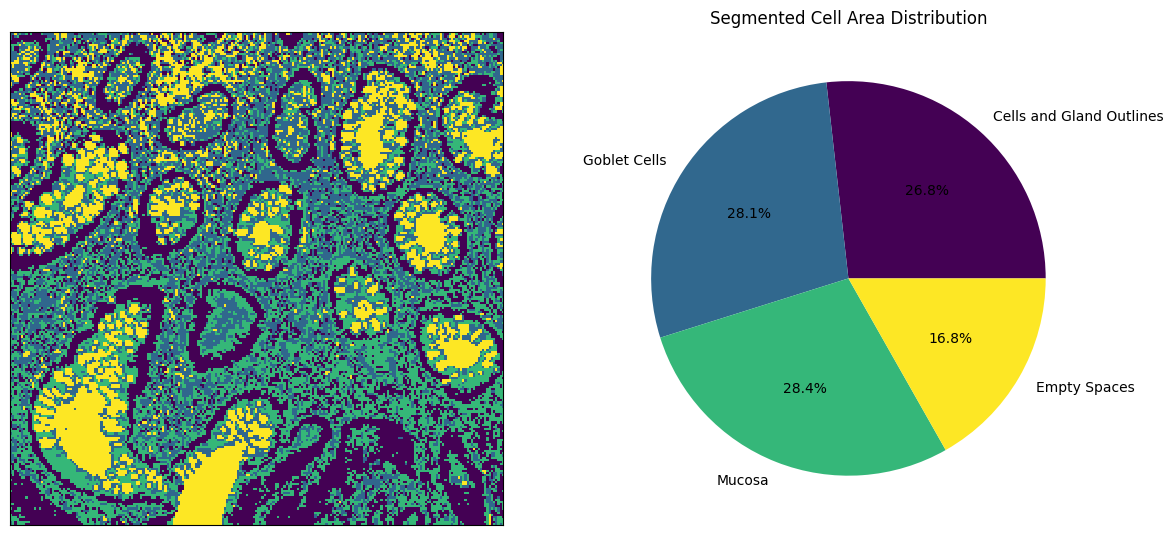

In [ ]:
pixel_values = denoise_img_as_8byte.reshape((-1, 1))

# Use k-means to cluster the pixels
kmeans = KMeans(n_clusters=4, random_state=1).fit(pixel_values)

# Assign each pixel to the closest cluster and reshape back to original image shape
segmented_img = kmeans.labels_.reshape(denoise_img_as_8byte.shape)

# Calculate the mean pixel intensity for each cluster
n_clusters = 4
mean_intensities = [np.mean(denoise_img_as_8byte[segmented_img == i]) for i in range(n_clusters)]

# Sort the clusters by mean intensity and assign segment labels based on the order
sorted_clusters = np.argsort(mean_intensities)
segment_labels = ['' for i in range(n_clusters)]
segment_labels[sorted_clusters[0]] = 'Cells and Gland Outlines'
segment_labels[sorted_clusters[1]] = 'Mucosa'
segment_labels[sorted_clusters[2]] = 'Goblet Cells'
segment_labels[sorted_clusters[3]] = 'Empty Spaces'

# Get the counts of each segment
counts = [np.count_nonzero(segmented_img == i) for i in range(n_clusters)]
labels = segment_labels

# Calculate the total number of pixels
total_pixels = np.prod(segmented_img.shape)

# Calculate the percentages for each segment
percentages = [(count / total_pixels) * 100 for count in counts]


# Define a color map for the clusters
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Create subplots and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

# Display the segmented image with different colors and labels for the different clusters
ax1.imshow(segmented_img, cmap=cmap, interpolation='nearest')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove the empty segment (if any)
nonzero_percentages = [p for p in percentages if p != 0]
nonzero_labels = [l for i, l in enumerate(labels) if percentages[i] != 0]

# Create a pie chart of the percentages
colors = cmap(np.arange(n_clusters))
nonzero_percentages = [p for p in percentages if p != 0]
nonzero_labels = [l for i, l in enumerate(labels) if percentages[i] != 0]
ax2.pie(nonzero_percentages, labels=nonzero_labels, autopct='%1.1f%%', colors=colors)
ax2.set_title('Segmented Cell Area Distribution')

# Show the plot
plt.show()

In [ ]:
# Define the path to the directory containing your images
image_directory = "/content/drive/MyDrive/MHIST/"
# Define the extension of the images you want to read
image_extension = "*.png" #.PNG for jupyter/.png for colab

# Define the directory to save the segmented images
save_directory = "/content/drive/MyDrive/Clustered_Images/"

# Retrieve a list of image file paths
image_paths = glob.glob(image_directory + image_extension)

# Iterate over the image paths
for image_path in image_paths:
    # Read the image
    img = cv2.imread(image_path)

    # Convert MxNx3 image into Kx3 where K=MxN
    img2 = img.reshape((-1, 3))
    img2 = np.float32(img2)

    # Define criteria, number of clusters, and apply k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 4
    attempts = 10
    ret, label, center = cv2.kmeans(img2, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    # Convert center values from float32 back into uint8
    center = np.uint8(center)

    # Access the labels to regenerate the clustered image
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    # Extract the filename from the image path
    filename = os.path.basename(image_path)
    segmented_image_path = os.path.join(save_directory, filename)

    # Save the segmented image
    cv2.imwrite(segmented_image_path, res2)

## SSA Prediction with Random Forest Classifier

In [ ]:
# Filter the DataFrame for names with scores of 0
zero_scores = df[df['SSA Detected?'] == 0]
# Sample with score 0
names_with_zero_scores = zero_scores['Image Name'].sample(n=50, random_state=42).tolist()

# Sample with non-zero scores
non_zero_scores = df[df['SSA Detected?'] != 0]
names_with_non_zero_scores = non_zero_scores['Image Name'].sample(n=50, random_state=42).tolist()

# Combine the selected names
selected_names = names_with_zero_scores + names_with_non_zero_scores


list

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd

im_df = pd.DataFrame()
img_path = "/content/drive/MyDrive/Clustered_Images/"

for image in selected_names:
    image_path = glob.glob(os.path.join(img_path, image))
    if not image_path:
        continue  # Skip the image if it's not found in the directory

    image_path = image_path[0]  # Retrieve the image file path
    print(image)

    df_temp = pd.DataFrame()

    img_input = cv2.imread(os.path.join(img_path, image))

    if img_input.ndim == 3 and img_input.shape[-1] == 3:
        img = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    elif img_input.ndim == 2:
        img = img_input
    else:
        raise Exception("Please insert RGB/GrayScale Images")

    pixel_values = img.reshape(-1)
    df_temp["Pixel_Value"] = pixel_values
    df_temp["Image Name"] = image
    
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'Gabor' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)
                    # Now filter image and add values to new column
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df_temp[gabor_label] = filtered_img  # Modify this to add new column for each gabor
                    num += 1

    # Generate OTHER FEATURES and add them to the data frame

    # Feature 3 is canny edge
    edges = cv2.Canny(img, 100, 200)  # Image, min and max values
    edges1 = edges.reshape(-1)
    df_temp['Canny Edge'] = edges1  # Add column to original dataframe

    from skimage.filters import roberts, sobel, scharr, prewitt

    # Feature 4 is Roberts edge
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df_temp['Roberts'] = edge_roberts1

    # Feature 5 is Sobel
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df_temp['Sobel'] = edge_sobel1

    # Feature 6 is Scharr
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df_temp['Scharr'] = edge_scharr1

    # Feature 7 is Prewitt
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df_temp['Prewitt'] = edge_prewitt1

    # Feature 8 is Gaussian with sigma=3
    from scipy import ndimage as nd

    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df_temp['Gaussian s3'] = gaussian_img1

    # Feature 9 is Gaussian with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df_temp['Gaussian s7'] = gaussian_img3

    # Feature 10 is Median with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df_temp['Median s3'] = median_img1

    # Feature 11 is Variance with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df_temp['Variance s3'] = variance_img1  # Add column to original dataframe

    file_counter += 1
    im_df = im_df.append(df_temp)
    

MHIST_bbj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bqo.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_clk.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bnn.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_alf.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cpv.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bjo.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ang.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_agh.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_clx.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bsu.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cet.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_aid.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_amc.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_edc.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_doa.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_eed.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_emz.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_aje.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dqv.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ayu.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cli.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_djy.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_clj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cqe.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dus.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_efs.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cob.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cgl.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dtb.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ees.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dlu.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cxt.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cxj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dfj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dgr.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bwr.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_enn.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cyz.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ddn.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_eqg.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ach.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_adb.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dml.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_aaw.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_avo.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cok.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dbt.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dlc.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bpe.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dpy.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bnc.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_akn.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ayv.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bsm.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_avv.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bxi.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_caj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bex.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_amj.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cla.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ano.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_blh.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bvh.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cgt.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cbb.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ekf.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_eqy.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bnk.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dqq.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dkd.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_akk.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cyx.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_akm.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_awo.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cbx.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dwi.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_aoi.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bpk.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ems.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_egd.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cza.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bqg.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bor.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dmi.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dob.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_dkn.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bcl.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cic.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_chs.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cst.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ahb.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_ajw.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cwq.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_acf.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cyw.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_apv.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_eqa.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_cne.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


MHIST_bgh.png


<ipython-input-37-acfb391f3c5e>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im_df = im_df.append(df_temp)


In [ ]:
im_df.to_csv('im_df.csv')

In [ ]:
merged_df = pd.merge(im_df, df, on='Image Name')

In [ ]:
merged_df.tail(10) 

,Pixel_Value,Image Name,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,...,Canny Edge,Roberts,Sobel,Scharr,Prewitt,Gaussian s3,Gaussian s7,Median s3,Variance s3,SSA Detected?
5017590,137,MHIST_bgh.png,0,0,255,255,137,2,32,0,...,255,0.149020,1.198647e-01,1.312490e-01,1.047058e-01,137,148,137,32,1
5017591,175,MHIST_bgh.png,0,0,255,255,235,192,132,145,...,0,0.149020,9.038769e-02,9.290606e-02,8.852289e-02,139,149,137,32,1
5017592,137,MHIST_bgh.png,0,0,255,255,130,60,25,0,...,0,0.149020,3.725490e-02,2.794118e-02,4.967320e-02,144,150,175,100,1
5017593,175,MHIST_bgh.png,0,0,255,255,156,141,24,66,...,0,0.000000,1.053728e-01,1.053728e-01,1.053728e-01,151,151,175,64,1
5017594,175,MHIST_bgh.png,0,0,255,255,255,192,214,92,...,0,0.000000,3.925231e-17,0.000000e+00,3.925231e-17,159,153,175,0,1
5017595,175,MHIST_bgh.png,0,0,255,255,255,165,106,77,...,255,0.231373,1.175040e-01,1.239006e-01,1.162186e-01,169,154,175,86,1
5017596,234,MHIST_bgh.png,0,0,255,255,187,87,51,8,...,255,0.000000,2.140513e-01,2.391369e-01,1.807990e-01,178,155,175,199,1
5017597,234,MHIST_bgh.png,0,0,255,255,218,137,63,41,...,0,0.000000,1.635140e-01,1.608002e-01,1.697963e-01,187,156,234,107,1
5017598,234,MHIST_bgh.png,0,0,255,255,255,255,146,130,...,0,0.000000,5.784314e-02,4.338235e-02,7.712418e-02,194,157,234,87,1
5017599,234,MHIST_bgh.png,0,0,255,255,255,255,255,108,...,0,0.000000,1.962616e-17,3.925231e-17,7.850462e-17,198,157,234,0,1


In [ ]:
#Define the dependent variable that needs to be predicted (labels)
Y = merged_df["SSA Detected?"].values

#Define the independent variables
X = merged_df.drop(labels = ["Image Name","SSA Detected?"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)


# Import the model we are using
#RandomForestRegressor is for regression type of problems. 
#For classification we use RandomForestClassifier.
#Both yield similar results except for regressor the result is float
#and for classifier it is an integer. 

from sklearn.ensemble import RandomForestClassifier
# Instantiate model with n number of decision trees
model = RandomForestClassifier(n_estimators = 50, random_state = 42)


In [ ]:
# Train the model on training data
model.fit(X_train, y_train)

# verify number of trees used. If not defined above. 
#print('Number of Trees used : ', model.n_estimators)

#STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA
#AND CALCULATE THE ACCURACY SCORE
#First test prediction on the training data itself. SHould be good. 
prediction_test_train = model.predict(X_train)

#Test prediction on testing data. 
prediction_test = model.predict(X_test)


In [ ]:
#Let us check the accuracy on test data
from sklearn import metrics
#Print the prediction accuracy

#First check the accuracy on training data. This will be higher than test data prediction accuracy.
print ("Accuracy on training data = ", metrics.accuracy_score(y_train, prediction_test_train))
#Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))


Accuracy on training data =  0.9299271564094388
Accuracy =  0.8347636320153061


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, prediction_test)

array([[401929,  99972],
       [ 65846, 435773]])

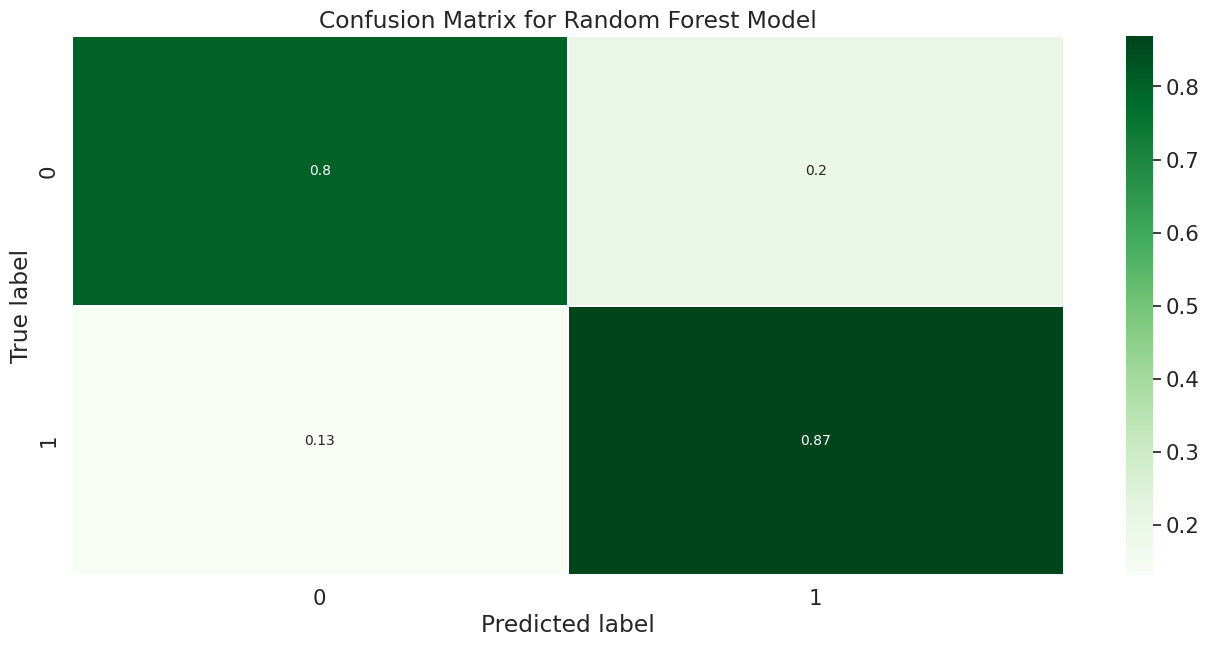

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, prediction_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)


plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# View the classification report for test data and predictions
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83    501901
           1       0.81      0.87      0.84    501619

    accuracy                           0.83   1003520
   macro avg       0.84      0.83      0.83   1003520
weighted avg       0.84      0.83      0.83   1003520



# CNN

## Model V3: deep/structured

In [ ]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown --id 1A-uoXUs8Ze08wN1TfinYjq0cSoeta5Ja

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1A-uoXUs8Ze08wN1TfinYjq0cSoeta5Ja
To: /content/images.zip
100% 349M/349M [00:06<00:00, 52.3MB/s]


In [ ]:
!unzip images.zip

Archive:  images.zip
  inflating: images/MHIST_aaa.png    
  inflating: images/MHIST_aab.png    
  inflating: images/MHIST_aac.png    
  inflating: images/MHIST_aad.png    
  inflating: images/MHIST_aae.png    
  inflating: images/MHIST_aaf.png    
  inflating: images/MHIST_aag.png    
  inflating: images/MHIST_aah.png    
  inflating: images/MHIST_aai.png    
  inflating: images/MHIST_aaj.png    
  inflating: images/MHIST_aak.png    
  inflating: images/MHIST_aal.png    
  inflating: images/MHIST_aam.png    
  inflating: images/MHIST_aan.png    
  inflating: images/MHIST_aao.png    
  inflating: images/MHIST_aap.png    
  inflating: images/MHIST_aaq.png    
  inflating: images/MHIST_aar.png    
  inflating: images/MHIST_aas.png    
  inflating: images/MHIST_aat.png    
  inflating: images/MHIST_aau.png    
  inflating: images/MHIST_aav.png    
  inflating: images/MHIST_aaw.png    
  inflating: images/MHIST_aax.png    
  inflating: images/MHIST_aay.png    
  inflating: images/MHIST_aaz

In [ ]:

from google.colab import files
 
 
uploaded = files.upload()

In [ ]:
# 2. Load the data

def load_and_preprocess_data():
    # Load annotations
    annotations = pd.read_csv('annotations.csv')

    # Load images and labels
    images = []
    labels = []
    for index, row in annotations.iterrows():
        img = cv2.imread(f'images/{row["Image Name"]}')
        img = cv2.resize(img, (224, 224))
        images.append(img)
        label = 1 if row["Majority Vote Label"] == "SSA" else 0
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalize the image data
    images /= 255

    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=2)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
# 3. Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
def build_cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    return model

In [ ]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

    return history, scores


In [ ]:
def save_model(model, file_name='colorectal_polyps_cnn_model.h5'):
    model.save(file_name)


In [ ]:
import matplotlib.pyplot as plt

def plot_performance(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
# Main code execution
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    model = build_cnn_model()
    history, scores = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    save_model(model)
    plot_performance(history)

## Model V4: V3 + pre-process

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import os
import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from skimage import io, color
from sklearn.cluster import KMeans
import cv2
from skimage.filters import roberts, sobel, scharr, prewitt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

In [ ]:
df=pd.read_csv("annotations.csv")
df.info()

In [ ]:
df=df.drop('Partition',axis=1)
sns.histplot(data=df['Majority Vote Label'])

In [ ]:
sns.countplot(data=df, y=df['Number of Annotators who Selected SSA (Out of 7)'], hue=df['Majority Vote Label'])

In [ ]:
k=df['Number of Annotators who Selected SSA (Out of 7)'].value_counts()

dc=k.to_dict()


In [ ]:
# directory path where the images are stored
directory_path = 'images'
# get the sorted list of keys
sorted_keys = sorted(dc.keys())

# get the number of keys
num_keys = len(sorted_keys)


del_n_rows=[]

# loop over the first half of the keys
for i in range(num_keys // 2):
    # get the corresponding values using indexing and slicing
    first_key = sorted_keys[i]
    last_key = sorted_keys[-i-1]
    first_value = dc[first_key]
    last_value = dc[last_key]
    
    # calculate the difference and print the result
    diff = abs(last_value - first_value)
    del_n_rows.append(diff)

for i in range(num_keys // 2):    
    to_delete = df.loc[df['Number of Annotators who Selected SSA (Out of 7)'] == sorted_keys[i]].sample(n=del_n_rows[i]).index
    df = df.drop(to_delete)

In [ ]:
sns.countplot(data=df, y=df['Number of Annotators who Selected SSA (Out of 7)'], hue=df['Majority Vote Label'])

In [ ]:
df=df.drop('Number of Annotators who Selected SSA (Out of 7)',axis=1)
df['Majority Vote Label'].replace({'SSA': 1, 'HP': 0}, inplace=True)
df.rename(columns={'Majority Vote Label': 'SSA Detected?'}, inplace=True)
df['SSA Detected?'] = pd.to_numeric(df['SSA Detected?'], downcast='integer')

In [ ]:
# list to store the images and labels
images = []
labels = []

# loop through each row in the DataFrame and append the image data and label to the lists
for index, row in df.iterrows():
    filename = row['Image Name']
    label = row['SSA Detected?']
    img_path = os.path.join(directory_path, filename)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        images.append(img)
        labels.append(label)
    else:
        print(f"Image {filename} not found")

# define the grid dimensions for subplots
rows = 2
cols = 5

# create a new figure with the given dimensions
fig = plt.figure(figsize=(10, 5))

# loop through the images and their corresponding labels and display them as subplots
for i in range(rows * cols):
    # check if there are still images and labels left to display
    if i >= len(images) or i >= len(labels):
        break
    # plot the image in a subplot
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(images[i])
    ax.axis('off')
    # add the corresponding label as the title of the subplot
    ax.set_title(f"Label: {labels[i]}")
    
plt.show()

In [ ]:
# list to store the images and labels for SSA detected images
ssa_images = []
ssa_labels = []

# list to store the images and labels for non-SSA detected images
non_ssa_images = []
non_ssa_labels = []

# loop through each row in the DataFrame and append the image data and label to the appropriate list
for index, row in df.iterrows():
    filename = row['Image Name']
    label = row['SSA Detected?']
    img_path = os.path.join(directory_path, filename)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        # check the value of the label and append the data to the appropriate list
        if label == 1:
            ssa_images.append(img)
            ssa_labels.append(label)
        else:
            non_ssa_images.append(img)
            non_ssa_labels.append(label)
    else:
        print(f"Image {filename} not found")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# images = np.array(images)
labels = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split

# split the SSA detected images and labels into training and validation sets
ssa_train_images, ssa_val_images, ssa_train_labels, ssa_val_labels = train_test_split(ssa_images, ssa_labels, test_size=0.2)

# split the non-SSA detected images and labels into training and validation sets
non_ssa_train_images, non_ssa_val_images, non_ssa_train_labels, non_ssa_val_labels = train_test_split(non_ssa_images, non_ssa_labels, test_size=0.2)

# concatenate the training and validation sets for each set of images and labels
train_images = ssa_train_images + non_ssa_train_images
train_labels = ssa_train_labels + non_ssa_train_labels
val_images = ssa_val_images + non_ssa_val_images
val_labels = ssa_val_labels + non_ssa_val_labels

# convert the training and validation data to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

# Shuffle the training data and labels
indices = np.random.permutation(len(train_images))
train_images = train_images[indices]
train_labels = train_labels[indices]

# Shuffle the validation data and labels
indices = np.random.permutation(len(val_images))
val_images = val_images[indices]
val_labels = val_labels[indices]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
    
model.add(Dense(2, activation='softmax'))

# Step 3: Compile the model
# -------------------------
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Step 4: Train the model
# -----------------------
# Use the training and validation data generated in the previous step
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=4, epochs=25)

# Step 5: Evaluate the model
# --------------------------
scores = model.evaluate(val_images, val_labels)
print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

## Model V5: V3 + Data augmentation/Learning rate scheduling

In [ ]:
# 2. Load the data

def load_and_preprocess_data():
    # Load annotations
    annotations = pd.read_csv('annotations.csv')

    # Load images and labels
    images = []
    labels = []
    for index, row in annotations.iterrows():
        img = cv2.imread(f'images/{row["Image Name"]}')
        img = cv2.resize(img, (224, 224))
        images.append(img)
        label = 1 if row["Majority Vote Label"] == "SSA" else 0
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalize the image data
    images /= 255

    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=2)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
# 3. Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
def build_cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen():
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, vertical_flip=True, zoom_range=0.1)
    return datagen


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    datagen = get_datagen()
    datagen.fit(X_train)

    # Use the augmented data during training
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=40, 
                    validation_data=(X_test, y_test), callbacks=[lr_scheduler])


    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

    return history, scores

In [ ]:
def save_model(model, file_name='colorectal_polyps_cnn_model.h5'):
    model.save(file_name)


In [ ]:
import matplotlib.pyplot as plt

def plot_performance(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
# Main code execution
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    model = build_cnn_model()
    history, scores = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    save_model(model)
    plot_performance(history)

## Model V6: V5 + class weights




In [ ]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

In [ ]:
# 2. Load the data

def load_and_preprocess_data():
    # Load annotations
    annotations = pd.read_csv('annotations.csv')

    # Load images and labels
    images = []
    labels = []
    for index, row in annotations.iterrows():
        img = cv2.imread(f'images/{row["Image Name"]}')
        img = cv2.resize(img, (224, 224))
        images.append(img)
        label = 1 if row["Majority Vote Label"] == "SSA" else 0
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalize the image data
    images /= 255

    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=2)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
# 3. Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
def build_cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen():
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, vertical_flip=True, zoom_range=0.1)
    return datagen


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:

def get_class_weights(labels):
    # Calculate class weights based on the inverse of class frequencies
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = {i: weight for i, weight in enumerate(weights)}
    return class_weights



In [ ]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, class_weights):
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    datagen = get_datagen()
    datagen.fit(X_train)

    # Use the augmented data during training
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=80, 
                    validation_data=(X_test, y_test), callbacks=[lr_scheduler], class_weight=class_weights)


    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

    return history, scores

In [ ]:
def save_model(model, file_name='colorectal_polyps_cnn_model_V6.h5'):
    model.save(file_name)


In [ ]:
import matplotlib.pyplot as plt

def plot_performance(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [ ]:
# Main code execution
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    model = build_cnn_model()
    class_weights = get_class_weights(np.argmax(y_train, axis=1))
    history, scores = train_and_evaluate_model(model, X_train, X_test, y_train, y_test, class_weights)
    save_model(model)
    plot_performance(history)

## Model V7: V6 + learning rate test


The main code of model V6 has been merged into one code cell for usability. the "class LearningRateRangeTest(Callback):" class has been added to compute the optimal 'initial_learning_rate' variable

In [ ]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# 1. Learning rate test
class LearningRateRangeTest(Callback):
    def __init__(self, min_lr, max_lr, num_iterations):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.num_iterations = num_iterations
        self.iteration = 0
        self.learning_rates = []
        self.losses = []

    def on_train_batch_begin(self, batch, logs=None):
        lr = self.min_lr + (self.max_lr - self.min_lr) * self.iteration / self.num_iterations
        self.iteration += 1
        self.learning_rates.append(lr)
        K.set_value(self.model.optimizer.lr, lr)

    def on_train_batch_end(self, batch, logs=None):
        self.losses.append(logs['loss'])

# Add the function to perform learning rate range test
def find_optimal_lr(model, X_train, y_train, min_lr=1e-6, max_lr=1e-2, num_iterations=200):
    lr_range_test = LearningRateRangeTest(min_lr, max_lr, num_iterations)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=32, callbacks=[lr_range_test], verbose=0)

    plt.plot(lr_range_test.learning_rates, lr_range_test.losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()


# 2. Load the data

def load_and_preprocess_data():
    # Load annotations
    annotations = pd.read_csv('annotations.csv')

    # Load images and labels
    images = []
    labels = []
    for index, row in annotations.iterrows():
        img = cv2.imread(f'images/{row["Image Name"]}')
        img = cv2.resize(img, (224, 224))
        images.append(img)
        label = 1 if row["Majority Vote Label"] == "SSA" else 0
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalize the image data
    images /= 255

    # One-hot encode the labels
    labels = to_categorical(labels, num_classes=2)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

# 3. Build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
def build_cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    return model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 4. Data augmentation
def get_datagen():
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, vertical_flip=True, zoom_range=0.1)
    return datagen

# 5. Learning rate scheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

initial_learning_rate = 0.00316
optimizer = Adam(learning_rate=initial_learning_rate)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 6. Class weighting

def get_class_weights(labels):
    # Calculate class weights based on the inverse of class frequencies
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = {i: weight for i, weight in enumerate(weights)}
    return class_weights

# 7. Training

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, class_weights):
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    datagen = get_datagen()
    datagen.fit(X_train)

    # Use the augmented data during training
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=80, 
                    validation_data=(X_test, y_test), callbacks=[lr_scheduler], class_weight=class_weights)


    # Evaluate the model
    scores = model.evaluate(X_test, y_test)
    print(f'Test loss: {scores[0]}, Test accuracy: {scores[1]}')

    return history, scores

def save_model(model, file_name='colorectal_polyps_cnn_model_V6.h5'):
    model.save(file_name)
import matplotlib.pyplot as plt


# 8. Graphs
def plot_performance(history):
    # Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()



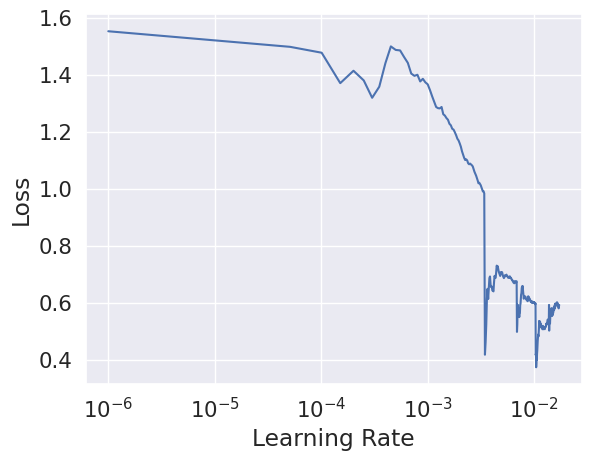

In [ ]:
# Learning rate search

# Load the data
X_train, X_test, y_train, y_test = load_and_preprocess_data()

# Build the model
model = build_cnn_model()

# Find the optimal learning rate
find_optimal_lr(model, X_train, y_train)


Epoch 1/80
69/69 [==============================] - 45s 459ms/step - loss: 1.0938 - accuracy: 0.5607 - val_loss: 0.9678 - val_accuracy: 0.3118 - lr: 0.0010
Epoch 2/80
69/69 [==============================] - 28s 411ms/step - loss: 0.8330 - accuracy: 0.6011 - val_loss: 0.6399 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 3/80
69/69 [==============================] - 28s 407ms/step - loss: 0.7478 - accuracy: 0.6215 - val_loss: 2.5237 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 4/80
69/69 [==============================] - 28s 406ms/step - loss: 0.6550 - accuracy: 0.6541 - val_loss: 1.7060 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 5/80
69/69 [==============================] - 28s 407ms/step - loss: 0.6453 - accuracy: 0.6763 - val_loss: 2.0659 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 6/80
69/69 [==============================] - 28s 405ms/step - loss: 0.6115 - accuracy: 0.6714 - val_loss: 2.6125 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 7/80
69/69 [==============================] - 28s 406ms/st

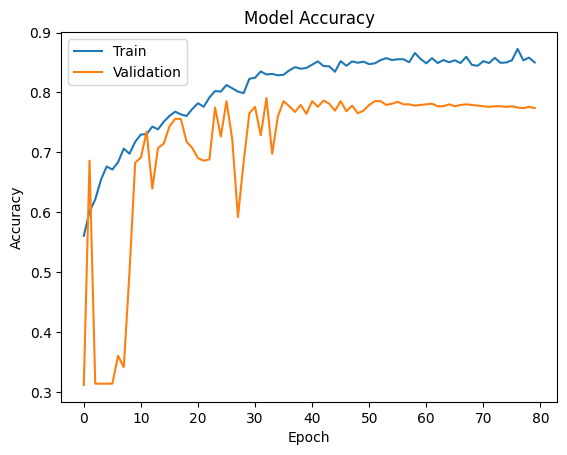

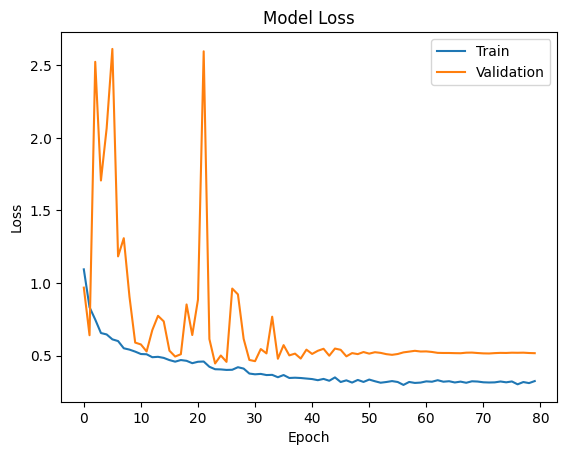

In [ ]:
# Main code execution
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    model = build_cnn_model()
    class_weights = get_class_weights(np.argmax(y_train, axis=1))
    history, scores = train_and_evaluate_model(model, X_train, X_test, y_train, y_test, class_weights)
    save_model(model)
    plot_performance(history)